In [496]:
import torch
import torch.nn as nn
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython import display
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

***
# Multi-output classifying ANN
- Goal is to make an ANN that can classify three different types of 'qwerties': A, B, and C.
- Create a dataset with 3 'data clouds'. They should have some overlap, but not just blend together. 
    - The center of the data clouds should be for the most part evenly spaced.
    - The 'blur' factor will help with the spacing of the random data points. It will help to keep the clustered around the center.
    - Want this problem to require a non-linear solution.

**General model architecture**
- This model should take two inputs, and produce 3 outputs (probabilities), with one of them being close to 1, and the other two being close to 0.
    - This model must have non-linear layers.
    - The cost function should be `nn.CrossEntropyLoss()`, because this is used in classification problems with more than one category.
        - Sigmoid would not work here, because it only works if there are two classes. 


- The `softmax` operation is necessary to use either as a non-linear activation layer or built into the `nn.CrossEntropyLoss()` function. 
- The model produces three outputs, and only the largest one will be used to classify the data point.
    - The `Softmax` layer does not need to be included in the model, because the `nn.CrossEntropyLoss()` has a logarithmic softmax built in.
        - I included it because the probabilities would not add up to one if this layer was left out.
        - The performance suffered and was unstable if this was left out.

***
***
## Functions to create data, build and train model.

In [497]:
# generating data

def create_data_cloud(num_per_cluster, blur_value):
# center of data cloud
    A = [1,7]
    B = [2.5,5.5]
    C = [4,7]

    # generating data points
    a = [A[0]+np.random.randn(num_per_cluster)*blur_value, A[1]+np.random.randn(num_per_cluster)*blur_value]
    b = [B[0]+np.random.randn(num_per_cluster)*blur_value, B[1]+np.random.randn(num_per_cluster)*blur_value]
    c = [C[0]+np.random.randn(num_per_cluster)*blur_value, C[1]+np.random.randn(num_per_cluster)*blur_value]

    # category labels (dummy or 'hot' encoding)
    labels_np = np.vstack((np.zeros((num_per_cluster,1)), np.ones((num_per_cluster, 1)), 1+np.ones((num_per_cluster,1)))) # all of dataset a is labeled as 0, all of b as 1, c as 2

    # concatenate data into matrix
    data_np = np.hstack((a,b,c)).T

    # convert numpy matrix to pytorch tensor
    data = torch.tensor(data_np).float()
    labels = torch.squeeze(torch.tensor(labels_np).long())

    return data, labels

In [498]:
# building model
def ANN_classify_build(m_learing_rate=0.01):
    ANN_model = nn.Sequential(
        nn.Linear(2,10), # input
        nn.ReLU(),       # non-linear activation
        nn.Linear(10,3),  # output
        nn.Softmax(dim=1)
    )

    # loss function
    loss_func = nn.CrossEntropyLoss() # final activation layer, implements log softmax and NLLLoss

    # optimizer
    model_optimizer = torch.optim.SGD(ANN_model.parameters(), lr=m_learing_rate)

    return ANN_model, loss_func, model_optimizer

In [499]:
# training model
def ANN_classify_training(model, loss_function, m_optimizer, input_data, input_labels, epochs = 1000):
    
    # parameters
    losses = torch.zeros(epochs)
    per_epoch_accuracy = []

    # quick model test
    test_y_hat = model(input_data)
    print('Size of input (batch_size,number_inputs) = ',input_data.shape)
    print('Size of output(batch_size,number_outputs) = ', test_y_hat.shape)

    # training
    for epoch_IDX in range(epochs):
        # forward pass
        y_hat = model(input_data)

        # calculating loss
        loss = loss_function(y_hat, input_labels)
        losses[epoch_IDX] = loss

        # backprop
        m_optimizer.zero_grad()
        loss.backward()
        m_optimizer.step()

        # calculating accuracy at each epoch
        matches = torch.argmax(y_hat, axis=1) == input_labels # converting to booleans (T / F)
        matches_num = matches.float()                         # convert bools to ints (0 / 1)
        accuracy_percent = 100*torch.mean(matches_num)        # average of correct matches
        per_epoch_accuracy.append(accuracy_percent)

    # final forward pass
    final_predictions = model(input_data)

    # overall accuracy
    predicted_lables = torch.argmax(final_predictions, axis=1)
    total_accuracy = 100*torch.mean((predicted_lables==input_labels).float())

    return final_predictions, losses, per_epoch_accuracy, total_accuracy, y_hat

***
### Actual experiment.

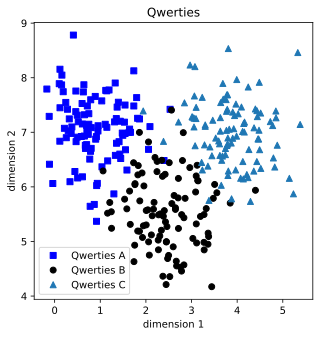

In [500]:
# creating data
test_data, test_labels = create_data_cloud(100,0.6)

# plotting data
fig = plt.figure(figsize=(5,5))

plt.plot(test_data[np.where(test_labels==0)[0],0], test_data[np.where(test_labels==0)[0],1], 'bs')
plt.plot(test_data[np.where(test_labels==1)[0],0], test_data[np.where(test_labels==1)[0],1], 'ko')
plt.plot(test_data[np.where(test_labels==2)[0],0], test_data[np.where(test_labels==2)[0],1], '^')

plt.title('Qwerties')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.legend(('Qwerties A', 'Qwerties B', 'Qwerties C'))

plt.show()

In [501]:
# building and training model
q_model, q_loss_func, q_model_optimizer = ANN_classify_build(0.01)

q_final_predictions, q_losses, q_per_epoch_acc, q_total_accuracy, q_y_hat = ANN_classify_training(q_model, q_loss_func, q_model_optimizer, test_data, test_labels, 10000)

Size of input (batch_size,number_inputs) =  torch.Size([300, 2])
Size of output(batch_size,number_outputs) =  torch.Size([300, 3])


Final accuracy: 93.6667%


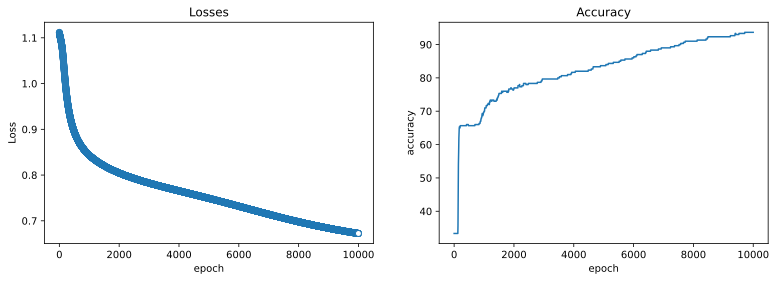

In [502]:
# plotting results
print('Final accuracy: %g%%'%q_total_accuracy)

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(q_losses.detach(), 'o', markerfacecolor='w', linewidth=0.1)
ax[0].set_title('Losses')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(q_per_epoch_acc)
ax[1].set_title('Accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')

plt.show()

In [503]:
# sanity checks, these should all sum up to one if things are working correctly.

#torch.sum(q_y_hat,axis=1)
#torch.sum(q_final_predictions, axis=1)

***
#### Lessons Learned
- I was experincing strange behavior, when I had the model layers initially set up like this:
```
ANN_model = nn.Sequential(
        nn.Linear(2,4), # input
        nn.ReLU(),       # non-linear activation
        nn.Linear(4,4),  # hidden layer
        nn.ReLU(),       # non-linear activation
        nn.Linear(4,3),  # output
    )
```
- Things that I experienced:
    - the probabilities of the final predictions did not sum up to 1 
    - accuracy that does not get above 50%
    - accuracy that is often stuck at 33.333% for some reason
    - the model is definitely not learning. The losses seem to plateau around 1 still.

- What fixed part of this issue:
```
 ANN_model = nn.Sequential(
        nn.Linear(2,4), # input
        nn.ReLU(),       # non-linear activation
        nn.Linear(4,3),  # output
        nn.Softmax(dim=1)
    )
```
- Getting rid of the hidden layer, and adding a final activation layer did seem to help.
    - the probabilities now add up to one
    - the model still is not learning
    - I kind of wonder if the error / cost function does not actually softmax the raw model output.

<br>

**Changes that helped**
- I changed the centers for each of the 'data clouds' in the `create_data_cloud()` function. As it turns out, the centers were too close together. The model performance improved to about 60% accurate most of the time.
- Got rid of the `nn.Softmax(dim=1)` layer, and the model performance jumped to an average of 80% accuracy. Not bad.
    - I actually think the model was performing suspiciously well, this layer is actually needed (I think).
- My model now looks like this:
```
ANN_model = nn.Sequential(
        nn.Linear(2,4), # input
        nn.ReLU(),       # non-linear activation
        nn.Linear(4,3),  # output
    )

    # loss function
    loss_func = nn.CrossEntropyLoss() # final activation layer, implements log softmax and NLLLoss

    # optimizer
    model_optimizer = torch.optim.SGD(ANN_model.parameters(), lr=m_learing_rate)
```
- Now the probabilities no longer sum up to 0. This is bad. It means that the predictions aren't reliable.

**Further explorations**

- Modified model to include last softmax non-linear activation layer.
- Also added more nodes.
- accuracy bounces between 60% and 80-90%
```
ANN_model = nn.Sequential(
        nn.Linear(2,10), # input
        nn.ReLU(),       # non-linear activation
        nn.Linear(10,3),  # output
        nn.Softmax(dim=1)
    )

    # loss function
    loss_func = nn.CrossEntropyLoss() # final activation layer, implements log softmax and NLLLoss

    # optimizer
    model_optimizer = torch.optim.SGD(ANN_model.parameters(), lr=m_learing_rate)

    return ANN_model, loss_func, model_optimizer
```

**More fine tuning**

- **This is a case where more epochs are needed** than what have been required in previous projects. 
    - To get an average accuracy around 80%-98% for each run, there should be at least 10K epochs. Wow.
    - The performance also stabilized when more epochs were added.